In [2]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Replace these with your actual values
server = 'LAPTOP-APF8MAGA\\SQLEXPRESS'
database = 'e_commerce'
driver = 'ODBC Driver 17 for SQL Server'

engine = create_engine(f'mssql+pyodbc://@{server}/{database}?trusted_connection=yes&driver={driver}')

# 1. Order Processing Phase

In [4]:
query = '''SELECT * 
FROM 
    olist_orders_dataset;

'''
orders = pd.read_sql(query, engine)

In [5]:
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


### Approval_Time

In [6]:
orders['approval_time'] = (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.days

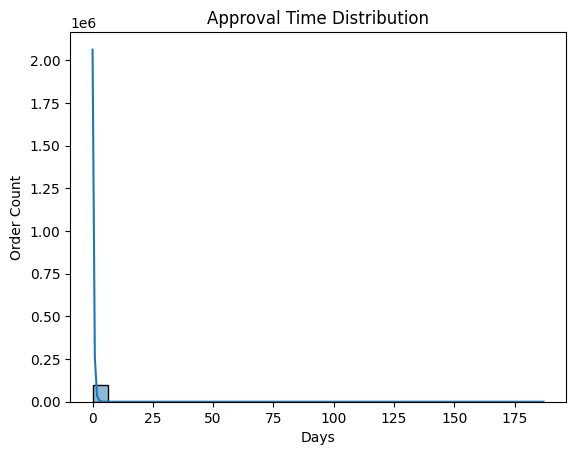

In [7]:
# Visualize
sns.histplot(orders['approval_time'].dropna(), bins=30, kde=True)
plt.title("Approval Time Distribution")
plt.xlabel("Days")
plt.ylabel("Order Count")
plt.show()

### Cancellation_Rate

In [8]:
cancellation_rate = (orders['order_status'] == 'canceled').mean()
print(f"Cancellation Rate: {cancellation_rate:.2%}")

Cancellation Rate: 0.63%


# 2. Shipping & Fulfillment Phase

### Fulfillment Time

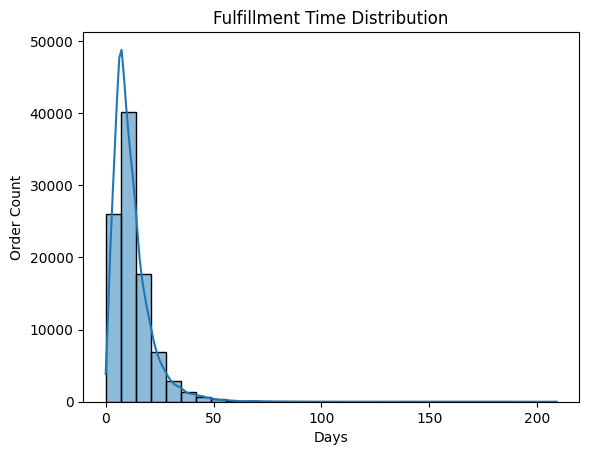

In [9]:
orders['fulfillment_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Visualize
sns.histplot(orders['fulfillment_time'].dropna(), bins=30, kde=True)
plt.title("Fulfillment Time Distribution")
plt.xlabel("Days")
plt.ylabel("Order Count")
plt.show()

### Shipping Time   

In [10]:
orders['shipping_time'] = (orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']).dt.days

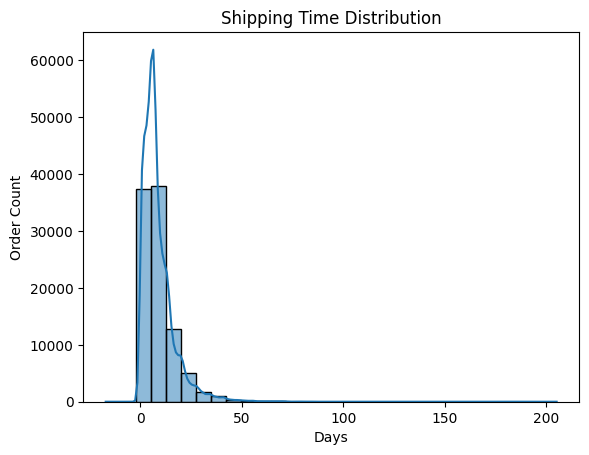

In [11]:
# Visualize
sns.histplot(orders['shipping_time'].dropna(), bins=30, kde=True)
plt.title("Shipping Time Distribution")
plt.xlabel("Days")
plt.ylabel("Order Count")
plt.show()

### On Time Delivery Rate

In [12]:
orders['on_time_delivery'] = orders['order_delivered_customer_date'] <= orders['order_estimated_delivery_date']
on_time_delivery_rate = orders['on_time_delivery'].mean()
print(f"On-Time Delivery Rate: {on_time_delivery_rate:.2%}")


On-Time Delivery Rate: 89.15%


### Delivery On-Time and Delays

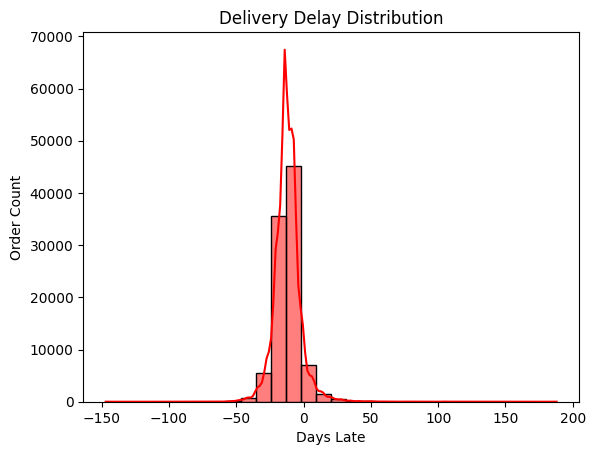

In [13]:
orders['delivery_delay_days'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

# Visualize
sns.histplot(orders['delivery_delay_days'].dropna(), bins=30, kde=True, color="red")
plt.title("Delivery Delay Distribution")
plt.xlabel("Days Late")
plt.ylabel("Order Count")
plt.show()

# 3. Customer Feedback Phase

In [14]:
query1 = '''SELECT 
    r.review_id,
    r.order_id, 
    r.review_score, 
    CASE 
        WHEN o.order_delivered_customer_date IS NULL 
          OR o.order_estimated_delivery_date IS NULL THEN NULL
        WHEN o.order_delivered_customer_date <= o.order_estimated_delivery_date THEN 1
        ELSE 0
    END AS on_time_delivery,
    p.product_category_name, 
    s.seller_id,
    s.seller_city, 
    s.seller_state 

FROM olist_order_reviews_dataset r
LEFT JOIN olist_orders_dataset o 
    ON r.order_id = o.order_id
LEFT JOIN olist_order_items_dataset oi 
    ON r.order_id = oi.order_id
LEFT JOIN olist_products_dataset p 
    ON oi.product_id = p.product_id
LEFT JOIN olist_sellers_dataset s 
    ON oi.seller_id = s.seller_id
'''
review = pd.read_sql(query1, engine)

In [15]:
review.head(5)

,review_id,order_id,review_score,on_time_delivery,product_category_name,seller_id,seller_city,seller_state
0,97ca439bc427b48bc1cd7177abe71365,00010242fe8c5a6d1ba2dd792cb16214,5,1.0,cool_stuff,48436dade18ac8b2bce089ec2a041202,volta redonda,SP
1,7b07bacd811c4117b742569b04ce3580,00018f77f2f0320c557190d7a144bdd3,4,1.0,pet_shop,dd7ddc04e1b6c2c614352b383efe2d36,sao paulo,SP
2,0c5b33dea94867d1ac402749e5438e8b,000229ec398224ef6ca0657da4fc703e,5,1.0,moveis_decoracao,5b51032eddd242adc84c38acab88f23d,borda da mata,MG
3,f4028d019cb58564807486a6aaf33817,00024acbcdf0a6daa1e931b038114c75,4,1.0,perfumaria,9d7a1d34a5052409006425275ba1c2b4,franca,SP
4,940144190dcba6351888cafa43f3a3a5,00042b26cf59d7ce69dfabb4e55b4fd9,5,1.0,ferramentas_jardim,df560393f3a51e74553ab94004ba5c87,loanda,PR


### Average Review Score

In [16]:
avg_review_score = review['review_score'].mean()
print(f"Average Review Score: {avg_review_score:.2f}")


Average Review Score: 4.02


### Review Score by Delay

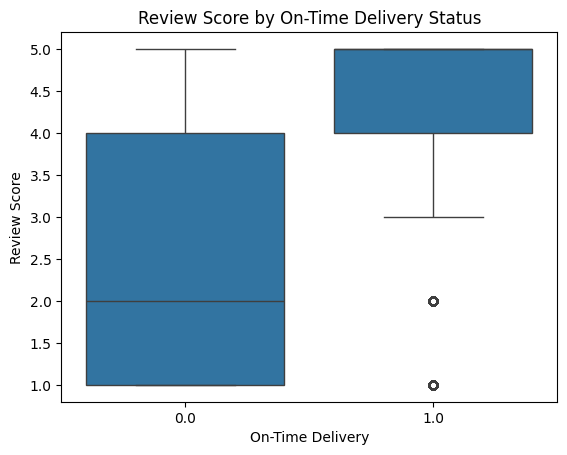

In [17]:
# Visualize
sns.boxplot(x=review['on_time_delivery'], y=review['review_score'])
plt.title("Review Score by On-Time Delivery Status")
plt.xlabel("On-Time Delivery")
plt.ylabel("Review Score")
plt.show()


### Review Score by Category and Seller

In [18]:
# By category
review_by_category = review.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)
print(review_by_category.head(10))


product_category_name
cds_dvds_musicais                     4.642857
fashion_roupa_infanto_juvenil         4.500000
livros_interesse_geral                4.446266
construcao_ferramentas_ferramentas    4.444444
flores                                4.419355
livros_importados                     4.400000
livros_tecnicos                       4.368421
alimentos_bebidas                     4.315412
malas_acessorios                      4.315257
portateis_casa_forno_e_cafe           4.302632
Name: review_score, dtype: float64


In [19]:
# By seller
review_by_seller = review.groupby('seller_id')['review_score'].mean().sort_values(ascending=False)
print(review_by_seller.head(10))

seller_id
1cd9e0cc1839d55516843def5600816d    5.0
9fbd5666d8618fa571c4230fafa09bd6    5.0
d3891911c2feae53c52fea2bd14054e5    5.0
702835e4b785b67a084280efca355756    5.0
a20d8058c866dbaeca014d2cd20ac62e    5.0
a213f1bd6458f4a158f3746cb2514559    5.0
1d953075c2f0dd990bacf27b83b330f1    5.0
404e1ba01358af4cd63f679b2c4d1fa1    5.0
a2b911e9ad40dc7d61c142a4683e2d85    5.0
70126eecc6aa1274392a1743866e9678    5.0
Name: review_score, dtype: float64


# 4. Payment & Value Metrics

In [20]:
query2 = '''SELECT 
    p.order_id,
    p.payment_type, 
    p.payment_value, 
    oi.product_id
    
FROM olist_order_payments_dataset p
LEFT JOIN olist_order_items_dataset oi
    ON p.order_id = oi.order_id
'''
payment = pd.read_sql(query2, engine)

In [21]:
payment.head(5)

,order_id,payment_type,payment_value,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,credit_card,72.190002,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,credit_card,259.829987,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,credit_card,216.869995,c777355d18b72b67abbeef9df44fd0fd
3,00024acbcdf0a6daa1e931b038114c75,credit_card,25.780001,7634da152a4610f1595efa32f14722fc
4,00042b26cf59d7ce69dfabb4e55b4fd9,credit_card,218.039993,ac6c3623068f30de03045865e4e10089


### Average Order Value

In [22]:
avg_order_value = payment.groupby('order_id')['payment_value'].sum().mean()
print(f"Average Order Value: {avg_order_value:.2f}")


Average Order Value: 205.86


### Payment Method Usage

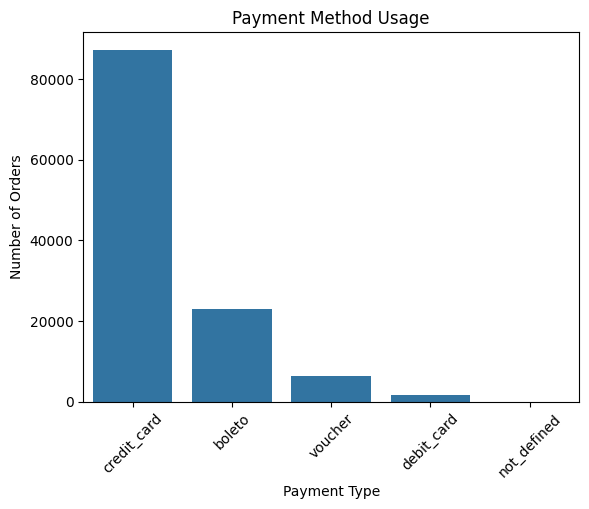

In [23]:
sns.countplot(data=payment, x='payment_type', order=payment['payment_type'].value_counts().index)
plt.title("Payment Method Usage")
plt.xlabel("Payment Type")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


### Average Basket Size

In [24]:
basket_size = payment.groupby('order_id')['product_id'].count()
avg_basket_size = basket_size.mean()
print(f"Average Basket Size: {avg_basket_size:.2f} products per order")


Average Basket Size: 1.18 products per order
